## 0.Import modules

In [1]:
import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
import json
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm
from heapq import nlargest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

from pandas_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder

Description

The aim of this competition is to predict e-commerce clicks, cart additions, and orders.
You'll build a multi-objective recommender system based on previous events in a user session.

## 1.Load data

In [2]:
### Paths ###
DATA_PATH = Path('../data')
TRAIN_RAW_PATH = DATA_PATH/'raw/train.jsonl'
TEST_RAW_PATH = DATA_PATH/'raw/test.jsonl'
SAMPLE_SUBMISSION_RAW_PATH = DATA_PATH/'raw/sample_submission.csv'

DATA_PROCESSED_PATH = DATA_PATH/'processed'

## 2.Convert json to pandas dataframe

In [ ]:
#Radek Osmulski's code

id2type = ['clicks', 'carts', 'orders']
type2id = {t: i for i, t in enumerate(id2type)}

id2type, type2id

(['clicks', 'carts', 'orders'], {'clicks': 0, 'carts': 1, 'orders': 2})

In [ ]:
pd.to_pickle(id2type, 'id2type.pkl')
pd.to_pickle(type2id, 'type2id.pkl')

In [11]:
def jsonl_to_df(path, chunk_size):
    """Load a jsonl file into a pandas dataframe"""
    sessions = []
    aids = []
    tss = []
    types = []

    chunks = pd.read_json(path, lines=True, chunksize = chunk_size)

    for chunk in tqdm(chunks):
        for row_idx, session_data in chunk.iterrows():
            num_events = len(session_data.events)
            sessions += ([session_data.session] * num_events)
            for event in session_data.events:
                aids.append(event['aid'])
                tss.append(event['ts'])
                types.append(type2id[event['type']])


    return pd.DataFrame(data = ({'session': sessions, 'aid': aids, 'ts': tss, 'type': types}))

In [12]:
train_df = jsonl_to_df(TRAIN_RAW_PATH, 100000)
train_df.type = train_df.type.astype(np.uint8)
train_df.to_parquet(DATA_PROCESSED_PATH/'train.parquet', index=False)
#train_df.to_csv(DATA_PROCESSED_PATH/'train.csv', index=False)

0it [00:00, ?it/s]

In [13]:
test_df = jsonl_to_df(TEST_RAW_PATH, 100000)
test_df.type = test_df.type.astype(np.uint8)
test_df.to_parquet(DATA_PROCESSED_PATH/'test.parquet', index=False)
#test_df.to_csv(DATA_PROCESSED_PATH/'test.csv', index=False)

0it [00:00, ?it/s]

In [5]:
#load raw data
#train_df = pd.read_parquet(DATA_PROCESSED_PATH/'train.parquet')
#test_df = pd.read_parquet(DATA_PROCESSED_PATH/'test.parquet')

In [6]:
test_df.head()

,session,aid,ts,type
0,12899779,59625,1661724000278,0
1,12899780,1142000,1661724000378,0
2,12899780,582732,1661724058352,0
3,12899780,973453,1661724109199,0
4,12899780,736515,1661724136868,0


In [16]:
#Find real sessions train
gap_beetwen_sessions = 1000*60*60*2

train_df = train_df.sort_values(['session','ts'])
train_df['session_real'] = train_df.groupby('session').ts.diff()
train_df.session_real = (train_df.session_real > gap_beetwen_sessions).astype('int8').fillna(0)
train_df['session_real'] = train_df.groupby('session').session_real.cumsum()
train_df['num_session_real'] = train_df.groupby('session').session_real.transform('max')
train_df['session_real_id'] = train_df.session.astype(str) + '_' + train_df.session_real.astype(str)

In [8]:
#Find real sessions test


test_df = test_df.sort_values(['session','ts'])
test_df['session_real'] = test_df.groupby('session').ts.diff()
test_df.session_real = (test_df.session_real > gap_beetwen_sessions).astype('int8').fillna(0)
test_df['session_real'] = test_df.groupby('session').session_real.cumsum()
test_df['num_session_real'] = test_df.groupby('session').session_real.transform('max')
test_df['session_real_id'] = test_df.session.astype(str) + '_' + test_df.session_real.astype(str)

## 3.EDA

Insights

1. We observe many patterns above. Most users exhibit regular behavior. They click, cart and order at the same hours each day. Also most users like to shop on the same days of the each week. Most users are active during the waking hours of day but some users like to shop during the night while others are sleeping. We also notice that users shop in clusters of activity. Our challenge in this competition is that we must both predict the remainder of the last cluster (provided in test data) and predict new clusters (after last timestamp in test). Furthermore all users in test data (not displayed in this notebook) have less than 1 week data, so we must predict user behavior given little user history information (i.e. the RecSys "cold start" problem). Understanding users and their behavior will help us predict test users' future behavior!

2. Train Event Number Summary per Session {'mean': 16.799985178040647, 'min': 2, 'max': 500, 'count': 12899779}

3. Test Event Number Summary per Session {'mean': 4.144102504900398, 'min': 1, 'max': 458, 'count': 1671803}

3.1.
216.7M events in training set and 6.9M events in test set
12.8M sessions in training set and 1.6M sessions in test set
1.8M products in training set and 783K products in test set
194.7M clicks in training set and 6.2M clicks in test set
16.8M carts in training set and 570K carts in test set
5M orders in training set and 65K orders in test set

4. Train Percent of Sessions in Terms of Event Numbers
<10 events: 0.6391379263164121 
<50 events: 0.9246156077557608 
<150 events: 0.9861470494959642 
150 events or more: 0.013852950504035767

5. Test Percent of Sessions in Terms of Event Numbers
<10 events: 0.9071541323947857 
<50 events: 0.9947140901170772 
<150 events: 0.9997308295295558 
150 events or more: 0.0002691704704441851

6. The session length is much smaller, with an average of 4 events (~3 times smaller than for train)

7. 	type	Data	Count
0	0	train	89.850714
1	1	train	7.796464
2	2	train	2.352825
3	0	test	90.827371
4	1	test	8.227495
5	2	test	0.945133

8. There are 1,671,803 unique sessions (a session ~ a user)

9. There are 12,899,779 unique sessions (a session ~ a user) in the train data

10. 
unique event count:
for train:
70% of sessions have only 1 event type
17% of sessions have 2 event types
12% of sessions have all 3 event types
for test:
85% of sessions have only 1 event type (much higher than for train)
12% of sessions have 2 event types
1% of sessions have all 3 event types (much lower than for train - as number of orders in test is also much lower)

11. 
Start Train: 2022-07-31 22:00:00 
Finish Train: 2022-08-28 21:59:59 
Start Test: 2022-08-28 22:00:00 
Finish Test: 2022-09-04 21:59:51

12. Looks like Sundays are the most active days of the month, with the highest activity happening then! There is somewhat of a pattern of "lazy" Mondays and a decend in activity until Thursday, with Friday beginning to surge again with the peak on Sunday.

13. 
~45% of sessions have registered activity in less than 1 day. Which means more than half of the sessions have activity on 1 or multiple days!
for the rest it looks like it's an even 10%:
~10% of sessions have registered activity for 5->10 days
~10% of sessions have registered activity for 10->15 days
~10% of sessions have registered activity for 15->20 days
~10% of sessions have registered activity for 20->25 days
we have some strong outliers too, with ~4% of sessions having 25+ days of registered activity

14. 
train: 1,855,603 unique products
test: 783,486 unique products
there is no product in the test set that doesn't appear at least once in the train set

15. Vast majority (62% in train) of products are seen less than 30 times within the dataset. There are however some pretty strong outliers.

16. 
So there are quite a few products that appear in both Train and Test when looking at top 25 prods with most event types:
CLICKS: {'108125', '554660', '832192', '184976', '29735', '986164', '1460571', '485256'}
CARTS: {'33343', '152547', '554660', '832192', '29735', '258353', '986164', '544144', '1022566', '332654', '1462420', '1460571', '166037', '485256'}
ORDERS: {'923948', '29735', '1022566', '986164', '544144', '332654', '166037'}

On first glance (top 25 products) they do. 9/25 top products (with most interactions) appear in Train and Test (looking at the overall engagement). For "add to cart" the similarity is even stronger, with 14/25 aids being in boths Train and Test.

17. Only less than 10% of products have more than 10% from max clicks, carts and orders. This means that most products have very few interactions. We can decrease the number of products by filtering out products with less than 10% of max clicks, carts and orders.

18. But we dont have 2-4 product wich have much more interactions than others.

19. In test almost 70$ users have one session. In train 10% users have one session.

20. Lenght distribution by session
0.1      1.0
0.2      2.0
0.3      3.0
0.4      5.0
0.5      7.0
0.6     10.0
0.7     14.0
0.8     22.0
0.9     37.0
1.0    433.0

21. In test 80% uniq sessions have one unic item. In train - 20$

22. Almost 70% users have 1-2 unique items interactions. In train - 30%.

23. For users with one unique session and one unique product we have almost only clicks. 1485818 clicks, 14642 carts, 3043 orders.





### 3.0 EDA for data sample

In [9]:
sample_train_df.set_index('session', drop=True, inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


In [1]:
# Let's look at an example session and print out some basic info

# Sample the first session in the df
example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the session: \n {example_session[0]} \n')

# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# The timestamp is in milliseconds since 00:00:00 UTC on 1 January 1970
print(f'The first session elapsed: {str(timedelta(milliseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  
print(f'The first session contains the following frequency of actions: {action_counts}')

NameError: name 'sample_train_df' is not defined

In [14]:
### Extract information from each session and add it to the df ###

action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))
    
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_hours'] = sample_train_df['session_length_unix']*2.77778e-7  # Convert to hours
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

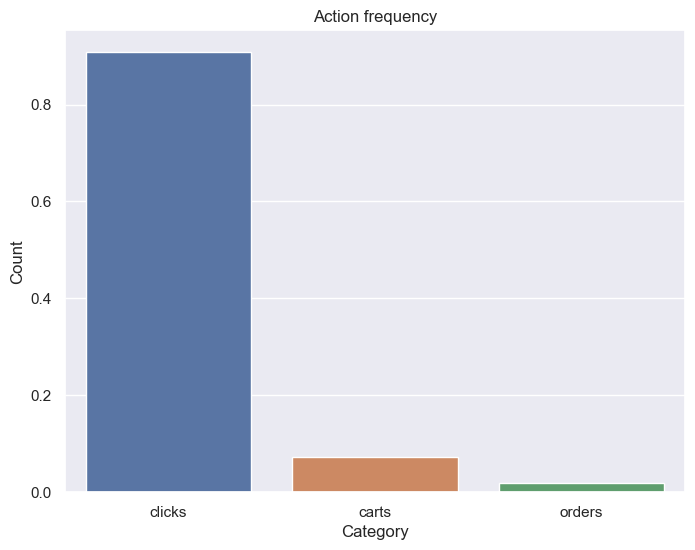

In [15]:
### Actions ###

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

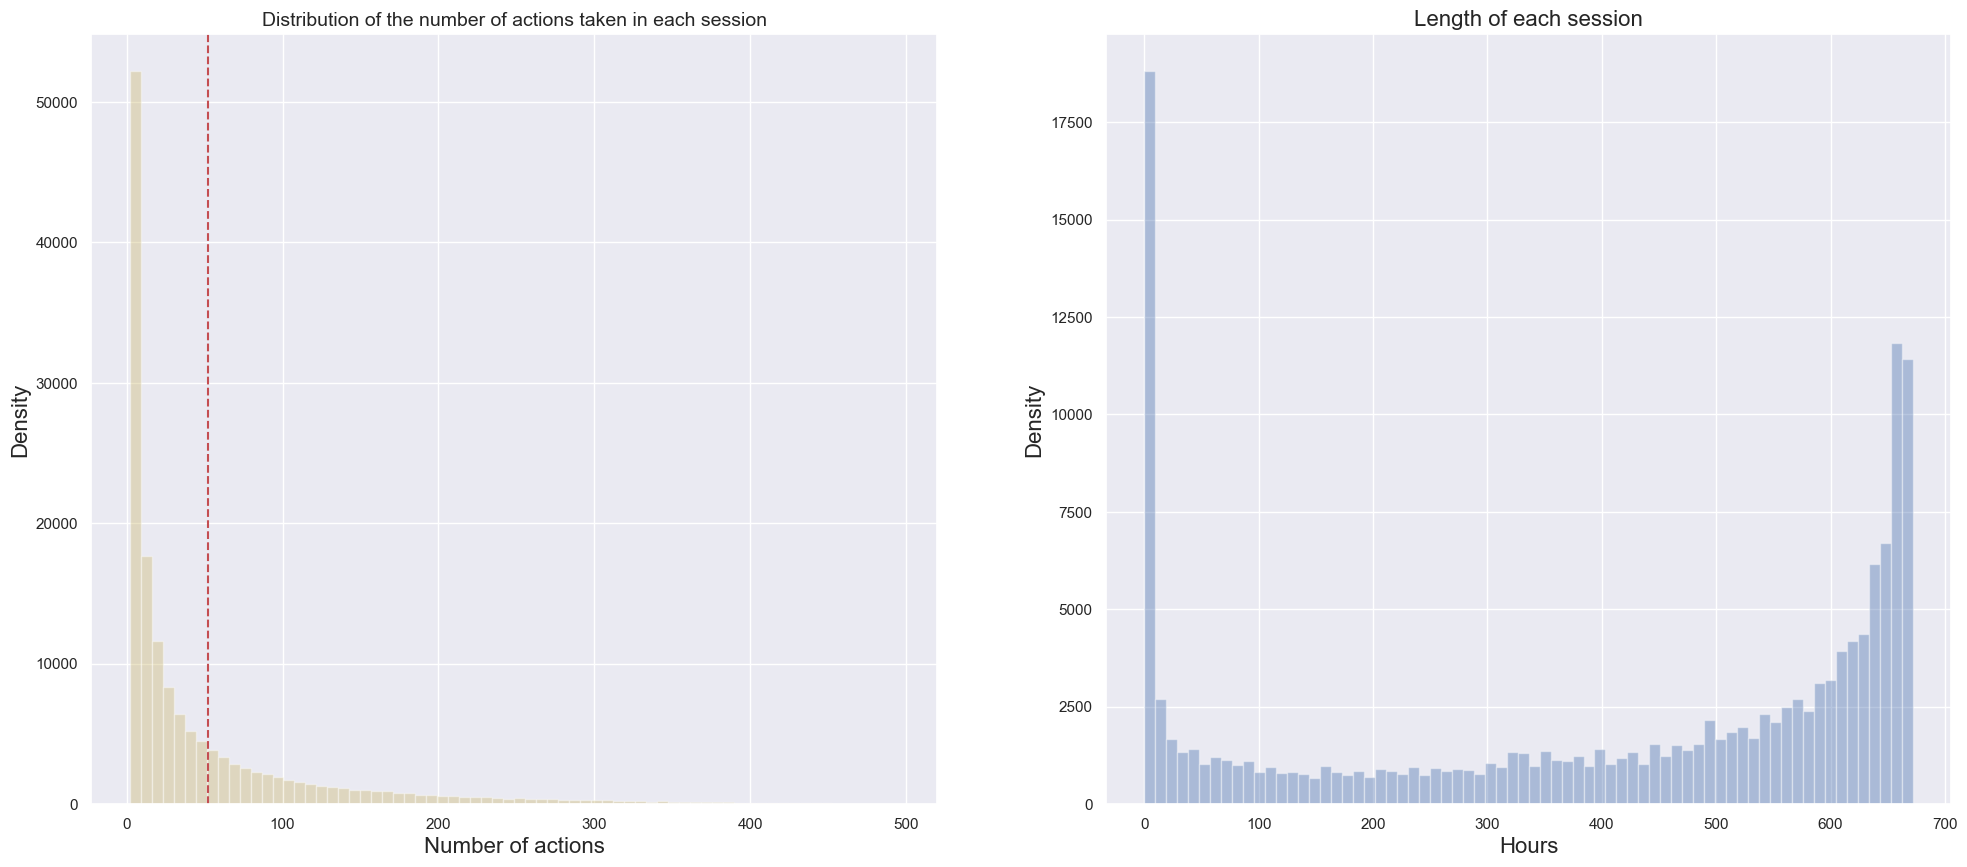

In [16]:
fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_hours'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Hours", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);

In [17]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


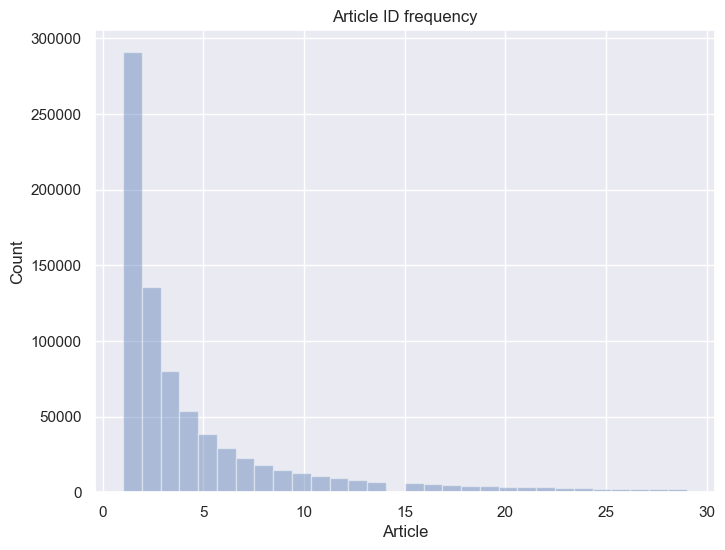

In [18]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

In [19]:
### Look at the most interacted with articles ###
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


### 3.1 Popular items

In [ ]:
profile = ProfileReport(test_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
#// find most popular aids with type 2 in train_df in percentage
train_df[train_df['type']==2]['aid'].value_counts().head(10)

231487     4485
166037     3824
1733943    3042
1445562    2998
1022566    2788
801774     2710
1629608    2628
756588     2593
332654     2436
1603001    2353
Name: aid, dtype: int64

In [23]:
#// find most popular aids with type 2 in test_df in percentage
test_df[test_df['type']==2]['aid'].value_counts(normalize=True).head(10)

986164     0.001130
1460571    0.001069
329725     0.000825
1043508    0.000825
332654     0.000718
688602     0.000687
29735      0.000672
1495817    0.000657
579690     0.000596
1022566    0.000596
Name: aid, dtype: float64

In [39]:
plt.rcParams['figure.figsize'] = [20, 10]

<AxesSubplot:>

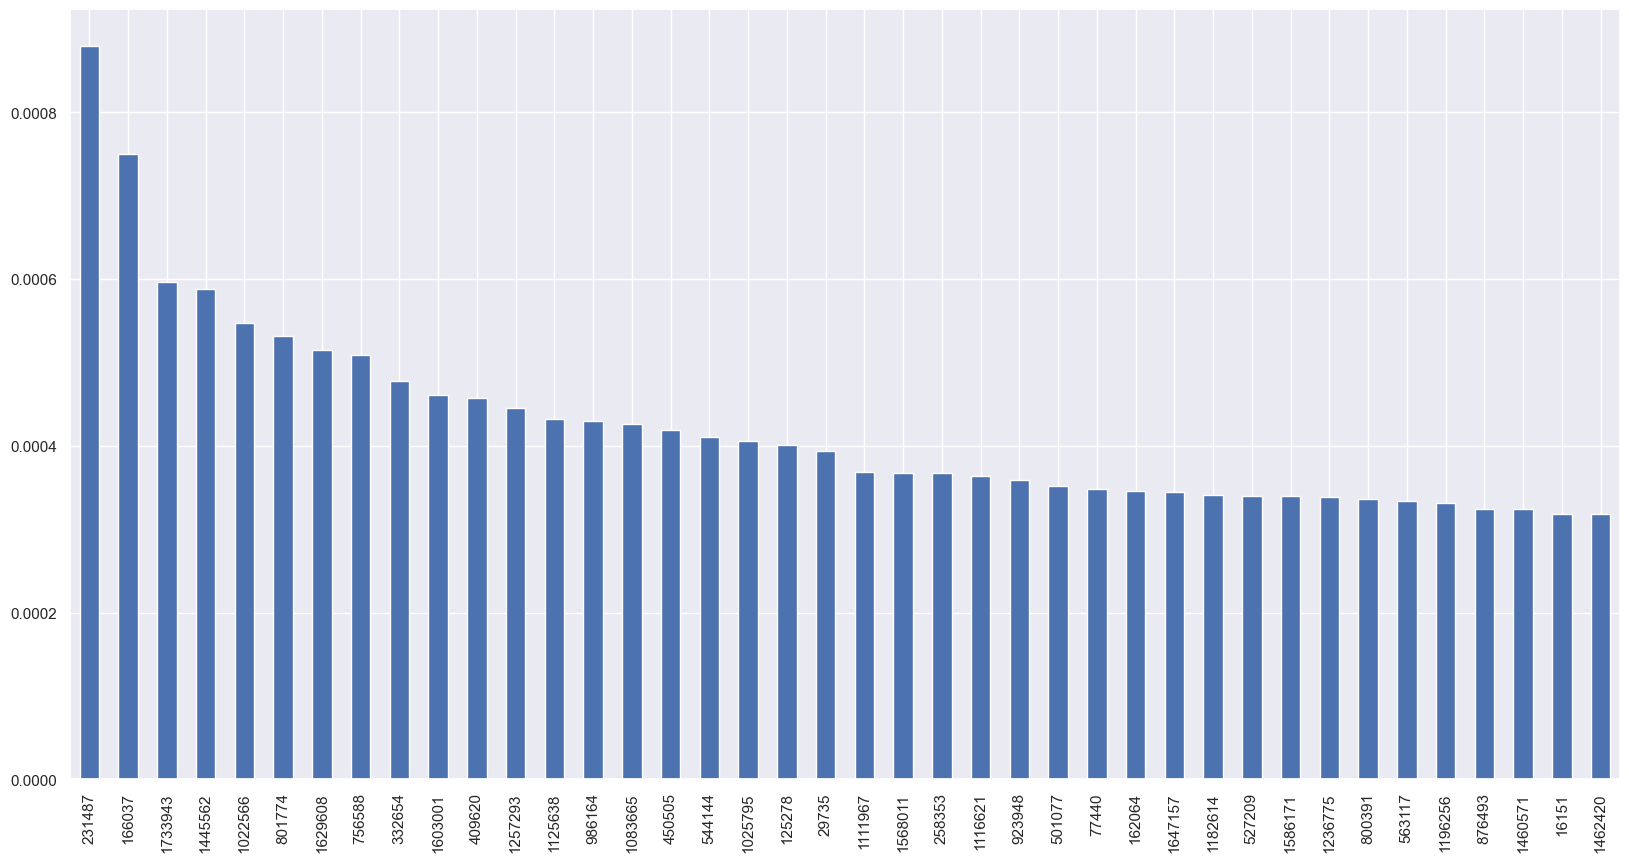

In [40]:
#// plot histogram of most popular aids with type 2 in train_df
train_df[train_df['type']==2]['aid'].value_counts(normalize=True).head(40).plot(kind='bar')

<AxesSubplot:>

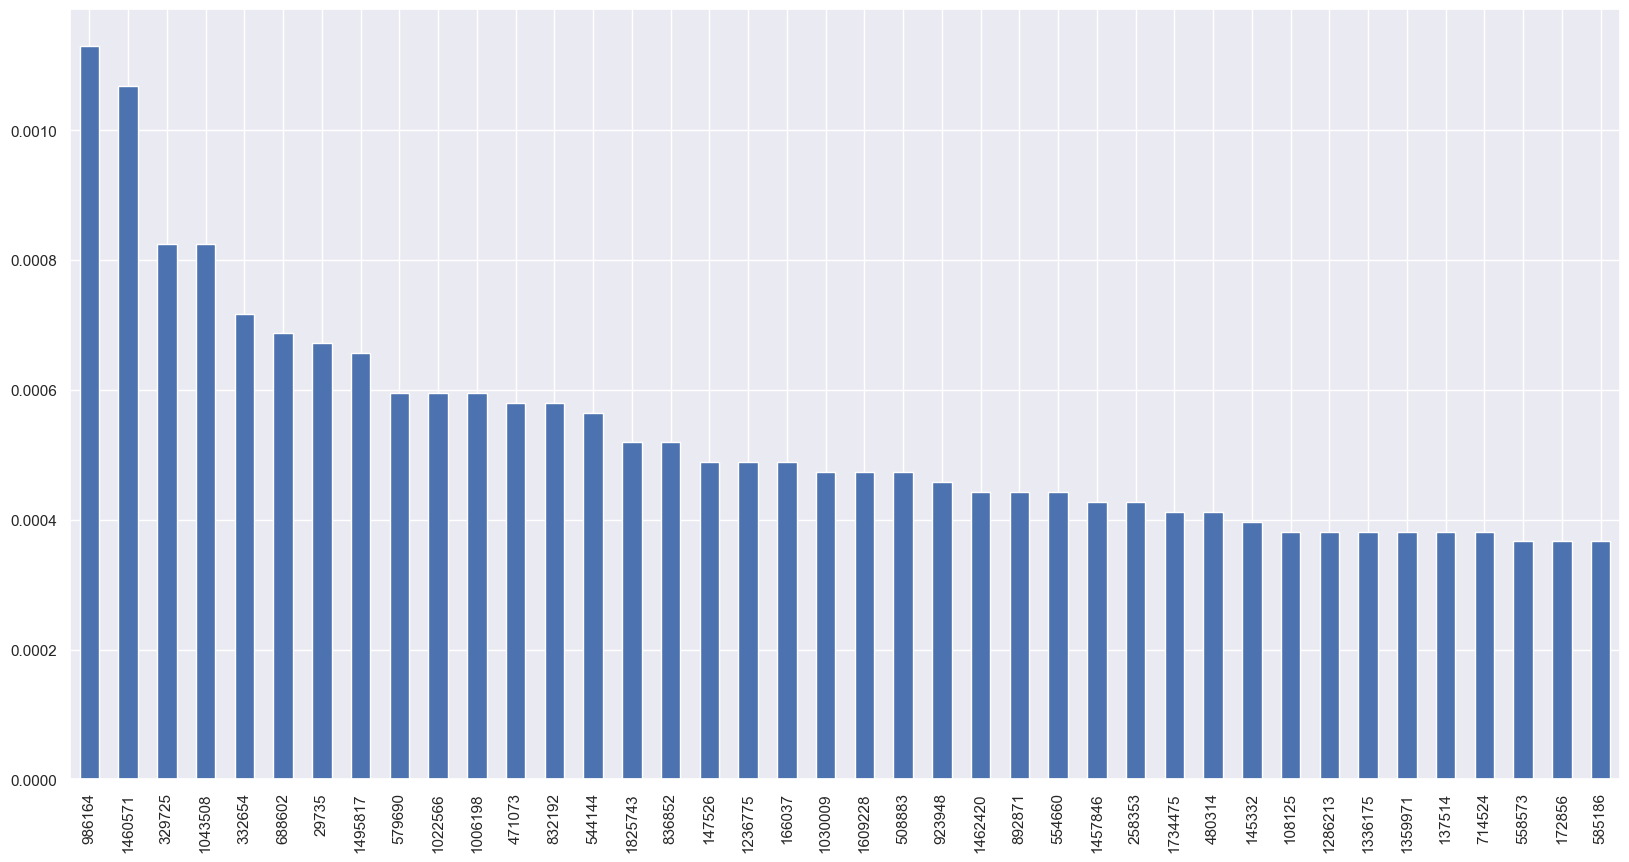

In [41]:
test_df[test_df['type']==2]['aid'].value_counts(normalize=True).head(40).plot(kind='bar')

<AxesSubplot:>

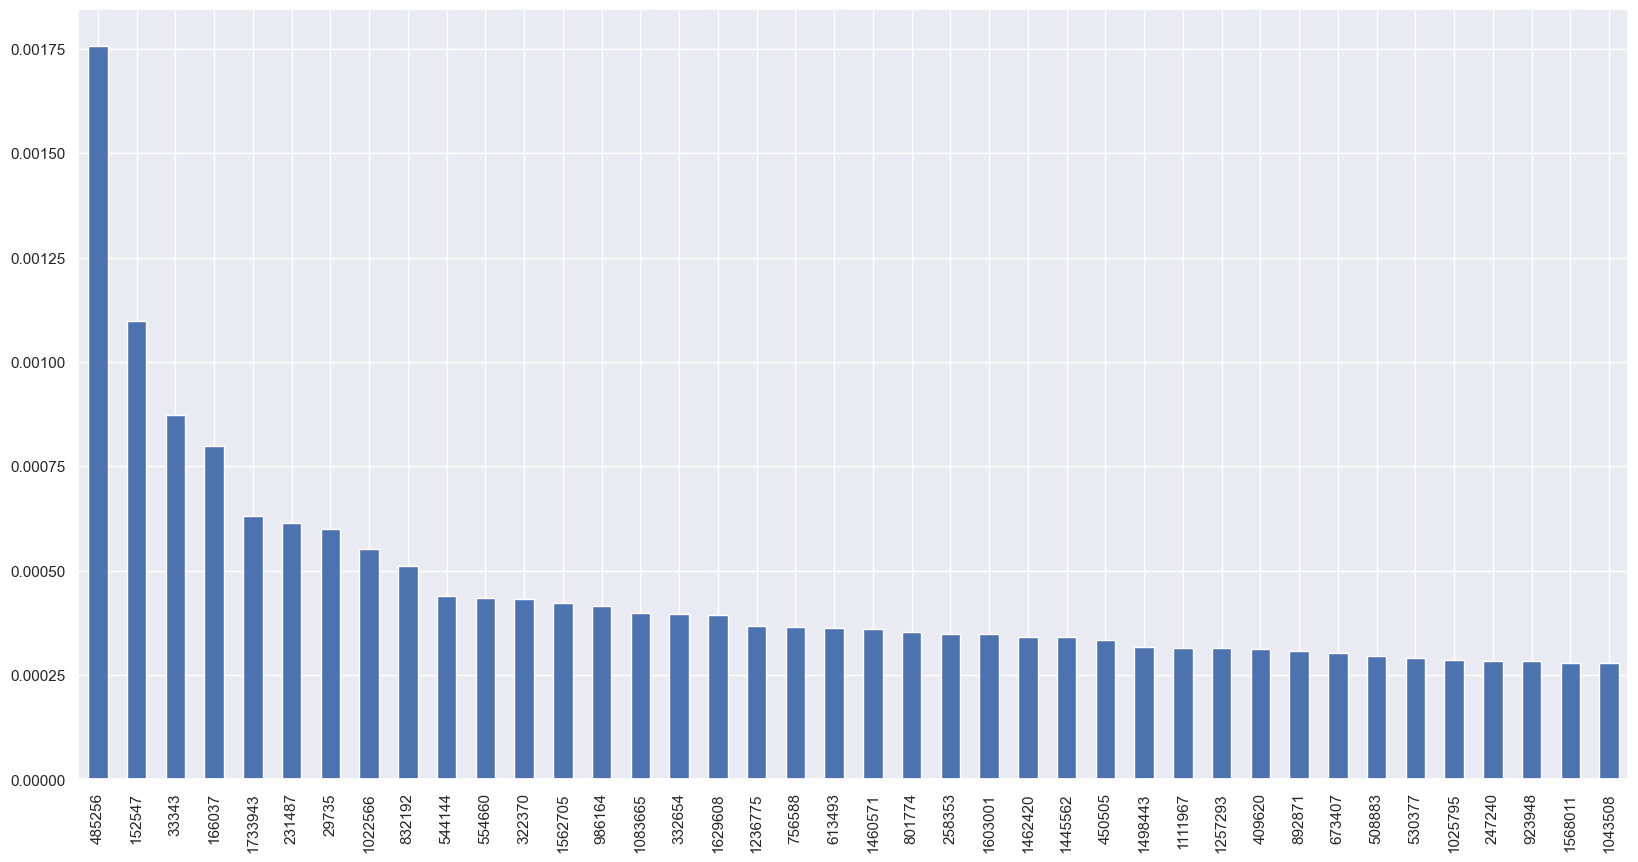

In [42]:
train_df[train_df['type']==1]['aid'].value_counts(normalize=True).head(40).plot(kind='bar')

<AxesSubplot:>

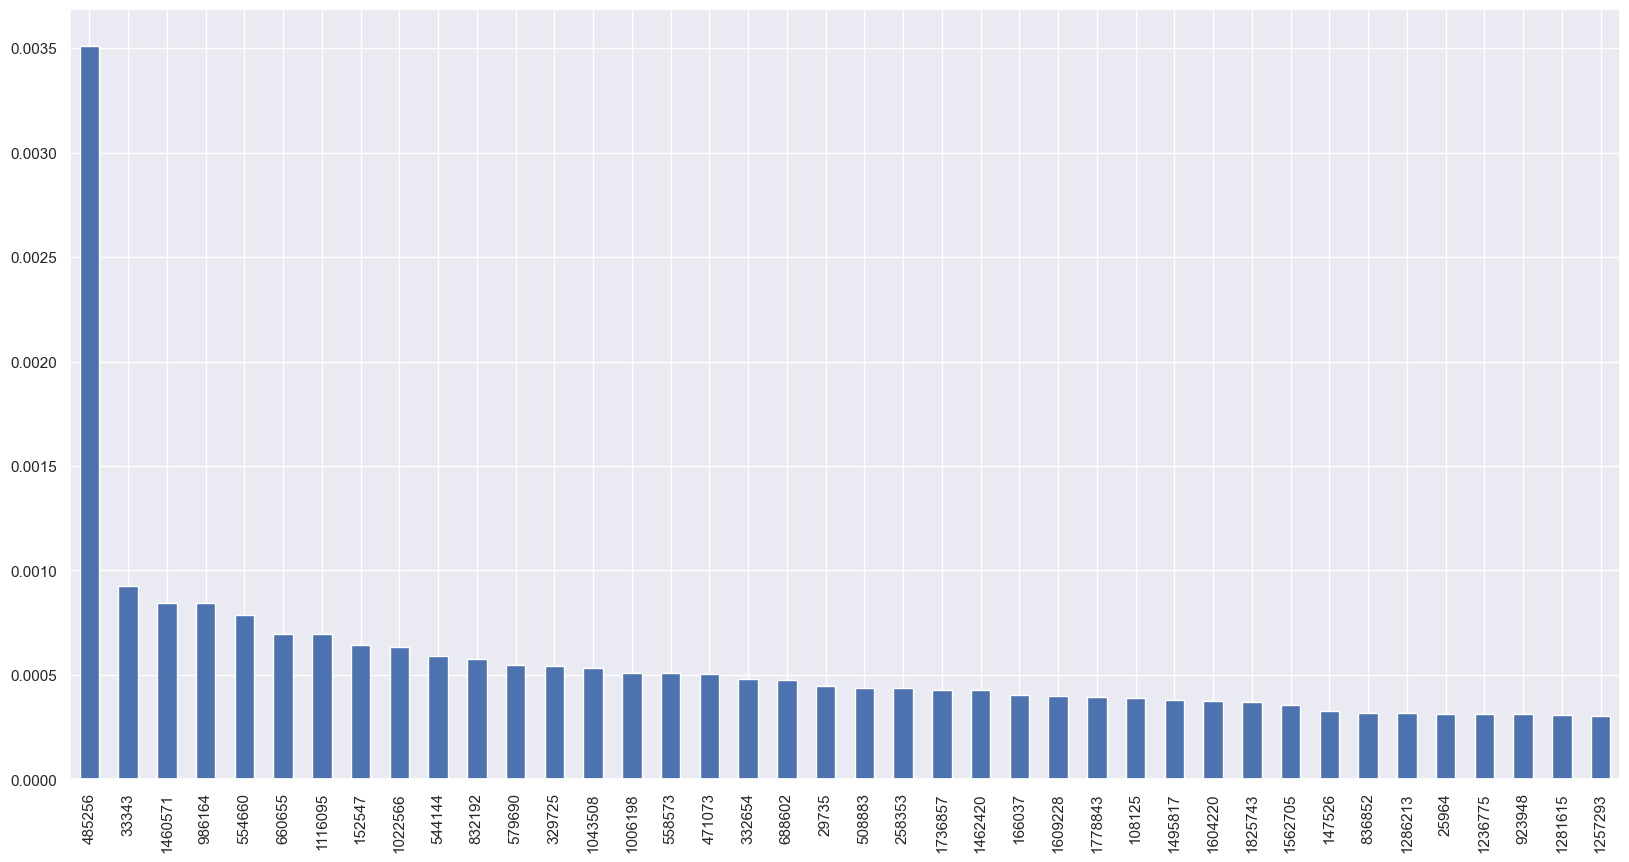

In [43]:
test_df[test_df['type']==1]['aid'].value_counts(normalize=True).head(40).plot(kind='bar')

<AxesSubplot:>

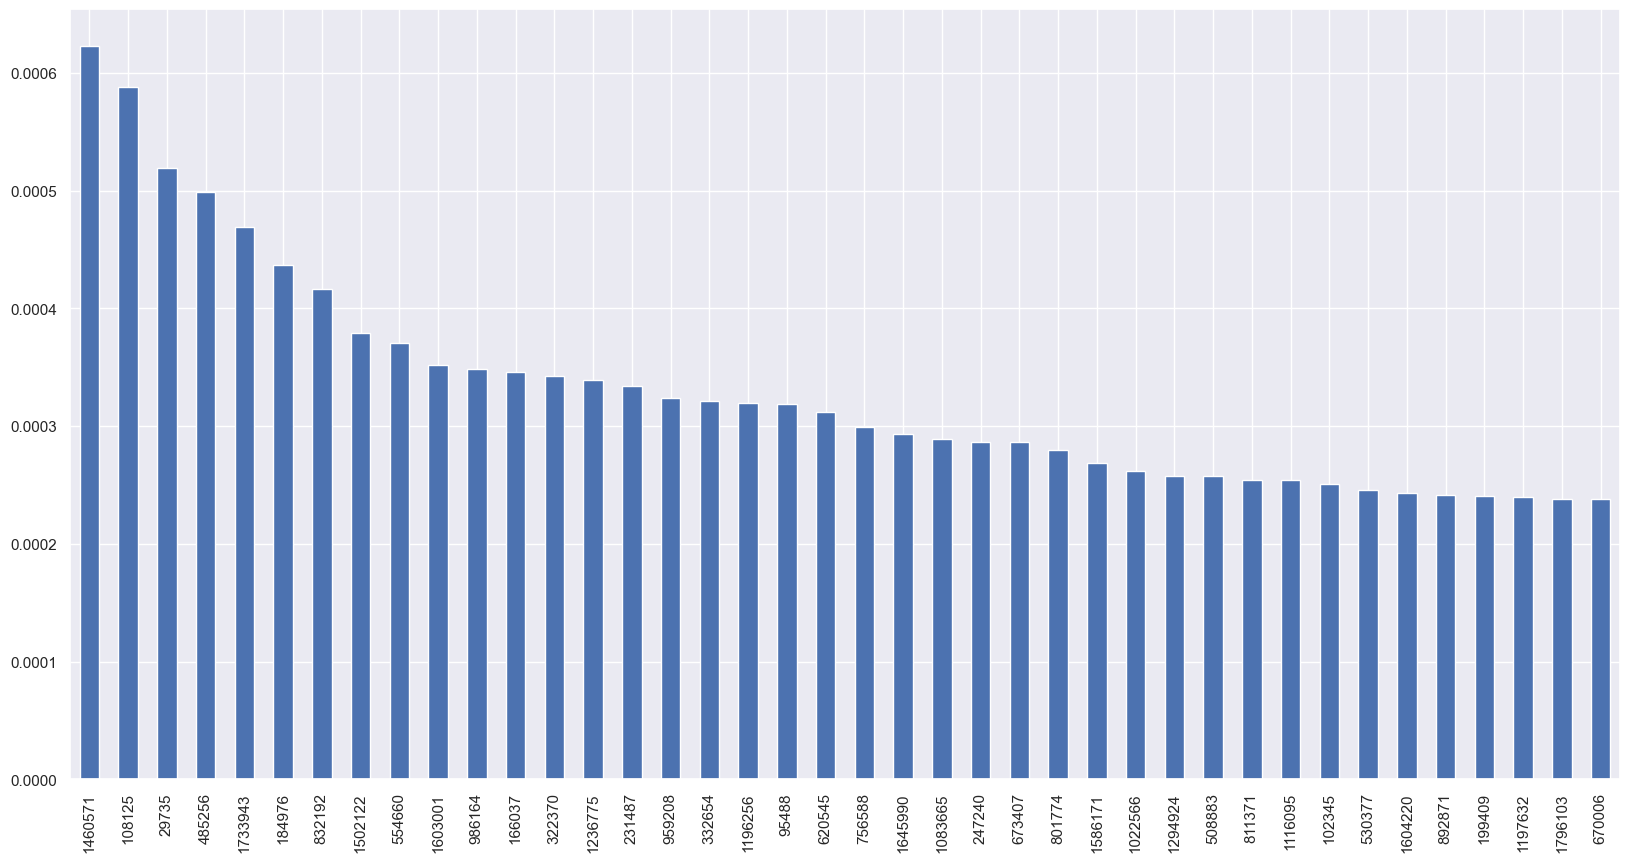

In [44]:
train_df[train_df['type']==0]['aid'].value_counts(normalize=True).head(40).plot(kind='bar')

<AxesSubplot:>

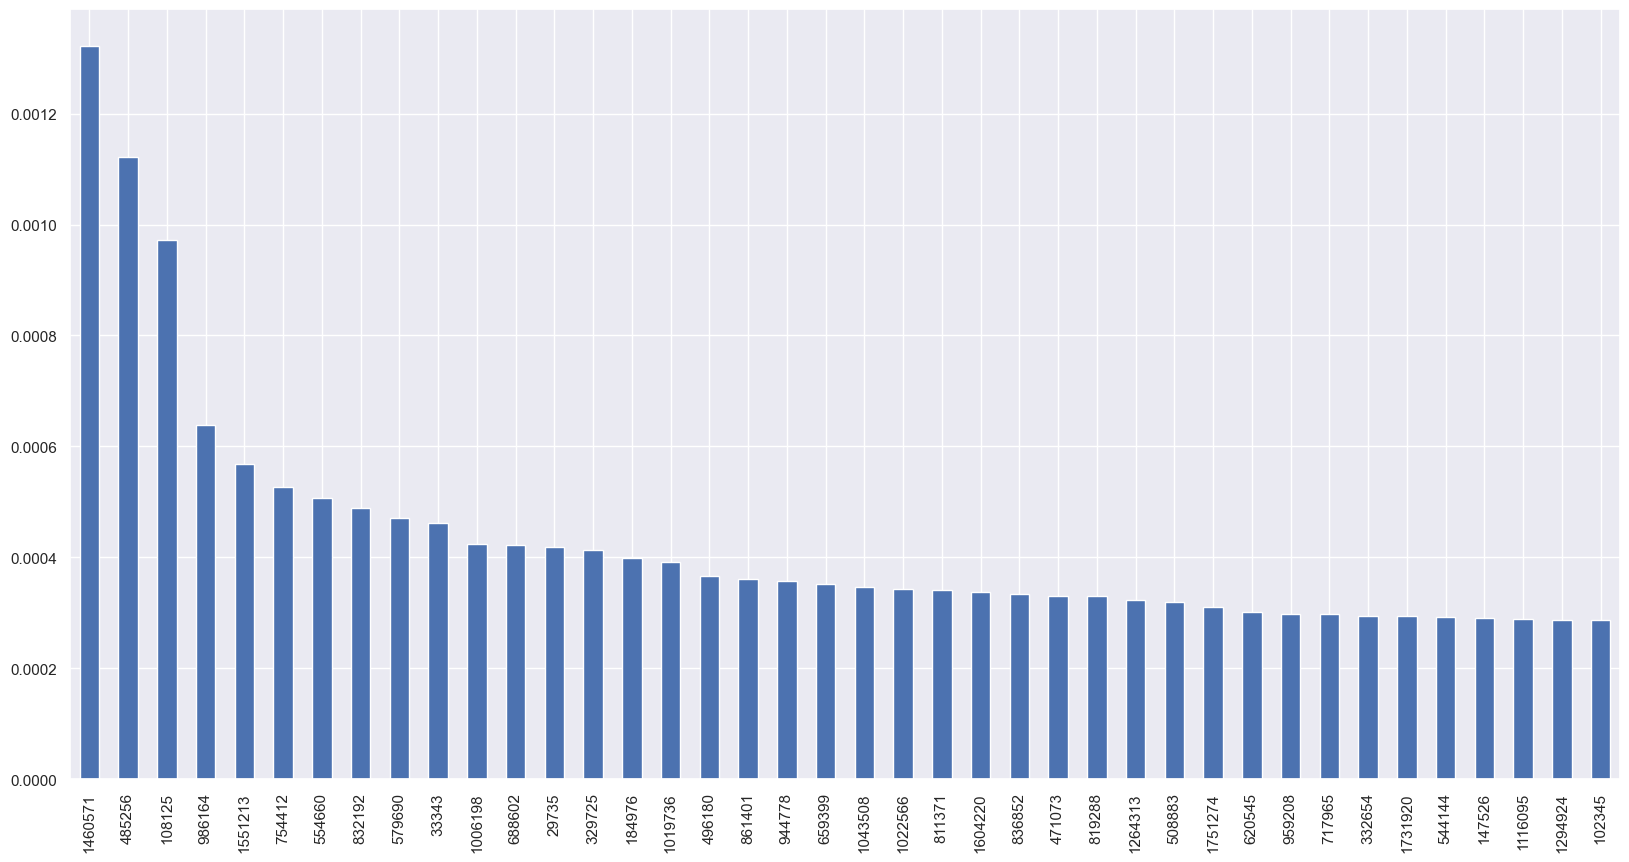

In [45]:
test_df[test_df['type']==0]['aid'].value_counts(normalize=True).head(40).plot(kind='bar')

In [9]:
#// new column with the number of appearances of each aid in train_df
train_df['aid_count'] = train_df.groupby('aid')['aid'].transform('count')
test_df['aid_count'] = test_df.groupby('aid')['aid'].transform('count')

#train_df

In [19]:
#// new column with the number of appearances of each aid where type == 2 in train_df
train_df['aid_count_type_0'] = train_df[train_df['type']==0].groupby('aid')['aid'].transform('count')
train_df['aid_count_type_1'] = train_df[train_df['type']==1].groupby('aid')['aid'].transform('count')
train_df['aid_count_type_2'] = train_df[train_df['type']==2].groupby('aid')['aid'].transform('count')
train_df = train_df.fillna(0)
train_df.head(10)

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,aid_count_type_2
0,0,1517085,1659304800025,0,0,47,0_0,121,105.0,0.0,0.0
1,0,1563459,1659304904511,0,0,47,0_0,84,84.0,0.0,0.0
2,0,1309446,1659367439426,0,1,47,0_1,5811,5118.0,0.0,0.0
3,0,16246,1659367719997,0,1,47,0_1,1646,1460.0,0.0,0.0
4,0,1781822,1659367871344,0,1,47,0_1,51,46.0,0.0,0.0
5,0,1152674,1659367885796,0,1,47,0_1,52,52.0,0.0,0.0
6,0,1649869,1659369893840,1,1,47,0_1,797,0.0,106.0,0.0
7,0,461689,1659369898050,1,1,47,0_1,5554,0.0,861.0,0.0
8,0,305831,1659370027105,2,1,47,0_1,2081,0.0,0.0,38.0
9,0,461689,1659370027105,2,1,47,0_1,5554,0.0,0.0,279.0


In [10]:
test_df['aid_count_type_0'] = test_df[test_df['type']==0].groupby('aid')['aid'].transform('count')
test_df['aid_count_type_1'] = test_df[test_df['type']==1].groupby('aid')['aid'].transform('count')
test_df['aid_count_type_2'] = test_df[test_df['type']==2].groupby('aid')['aid'].transform('count')
test_df = test_df.fillna(0)
test_df.head(10)

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,aid_count_type_2
0,12899779,59625,1661724000278,0,0,0,12899779_0,1,1.0,0.0,0.0
1,12899780,1142000,1661724000378,0,0,0,12899780_0,511,473.0,0.0,0.0
2,12899780,582732,1661724058352,0,0,0,12899780_0,371,333.0,0.0,0.0
3,12899780,973453,1661724109199,0,0,0,12899780_0,94,87.0,0.0,0.0
4,12899780,736515,1661724136868,0,0,0,12899780_0,563,488.0,0.0,0.0
5,12899780,1142000,1661724155248,0,0,0,12899780_0,511,473.0,0.0,0.0
6,12899781,141736,1661724000559,0,0,3,12899781_0,253,231.0,0.0,0.0
7,12899781,199008,1661724022851,0,0,3,12899781_0,437,400.0,0.0,0.0
8,12899781,57315,1661724170835,0,0,3,12899781_0,1105,1047.0,0.0,0.0
9,12899781,194067,1661724246188,0,0,3,12899781_0,40,38.0,0.0,0.0


In [138]:
#// get procentil distribution of aid_count_type_2 in train_df
train_df[train_df['type'] == 2].drop_duplicates(subset=['aid'])[['aid_count_type_2']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,aid_count_type_2
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,2.0
0.6,3.0
0.7,4.0
0.8,6.0
0.9,14.0
1.0,4485.0


<AxesSubplot:>

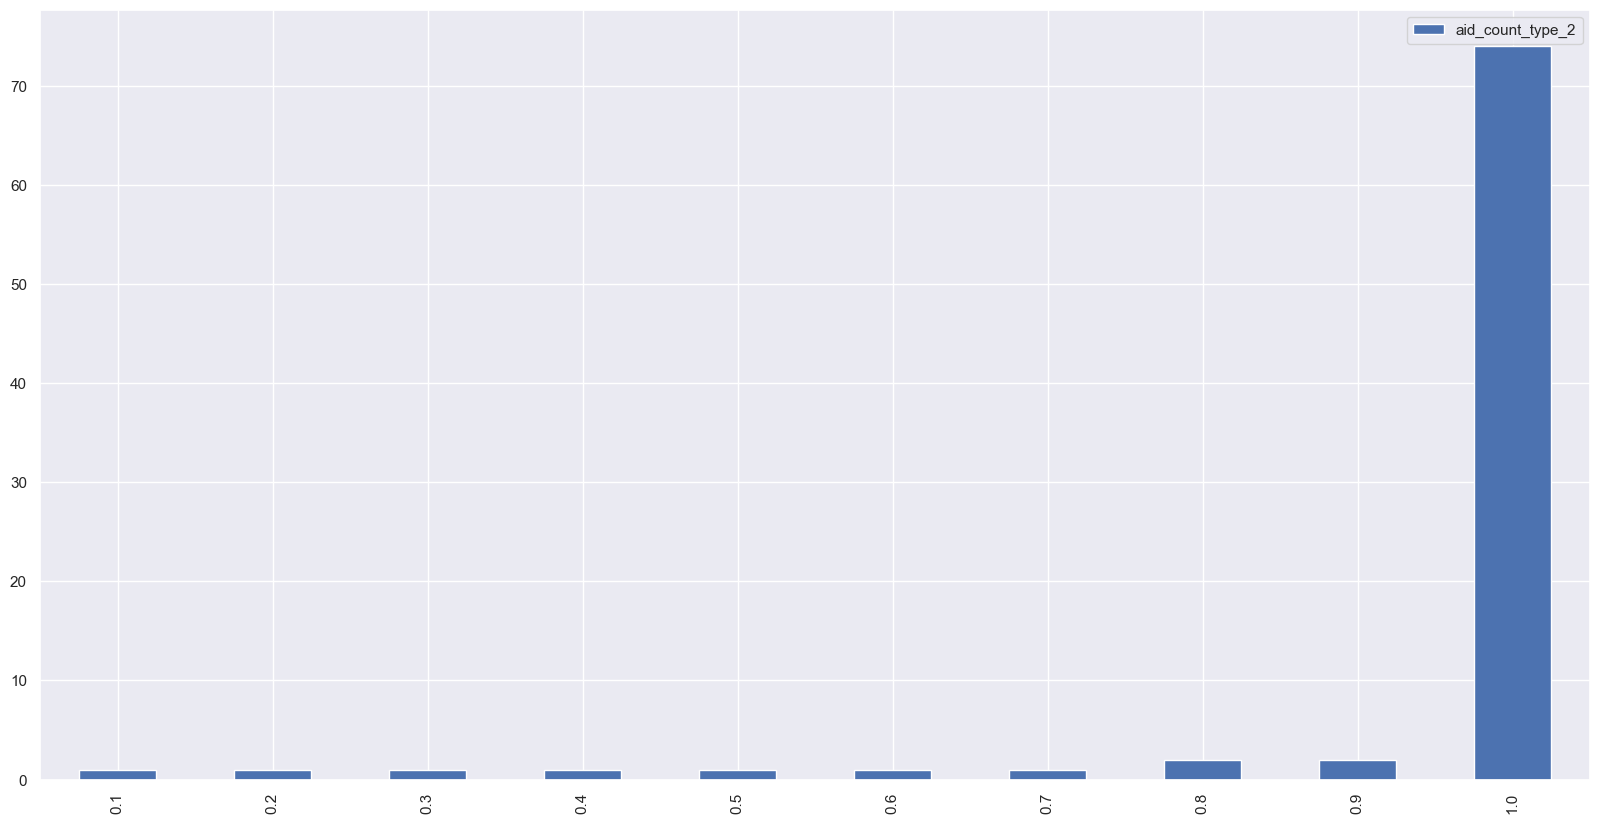

In [139]:
test_df[test_df['type'] == 2].drop_duplicates(subset=['aid'])[['aid_count_type_2']].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot(kind='bar')

<AxesSubplot:>

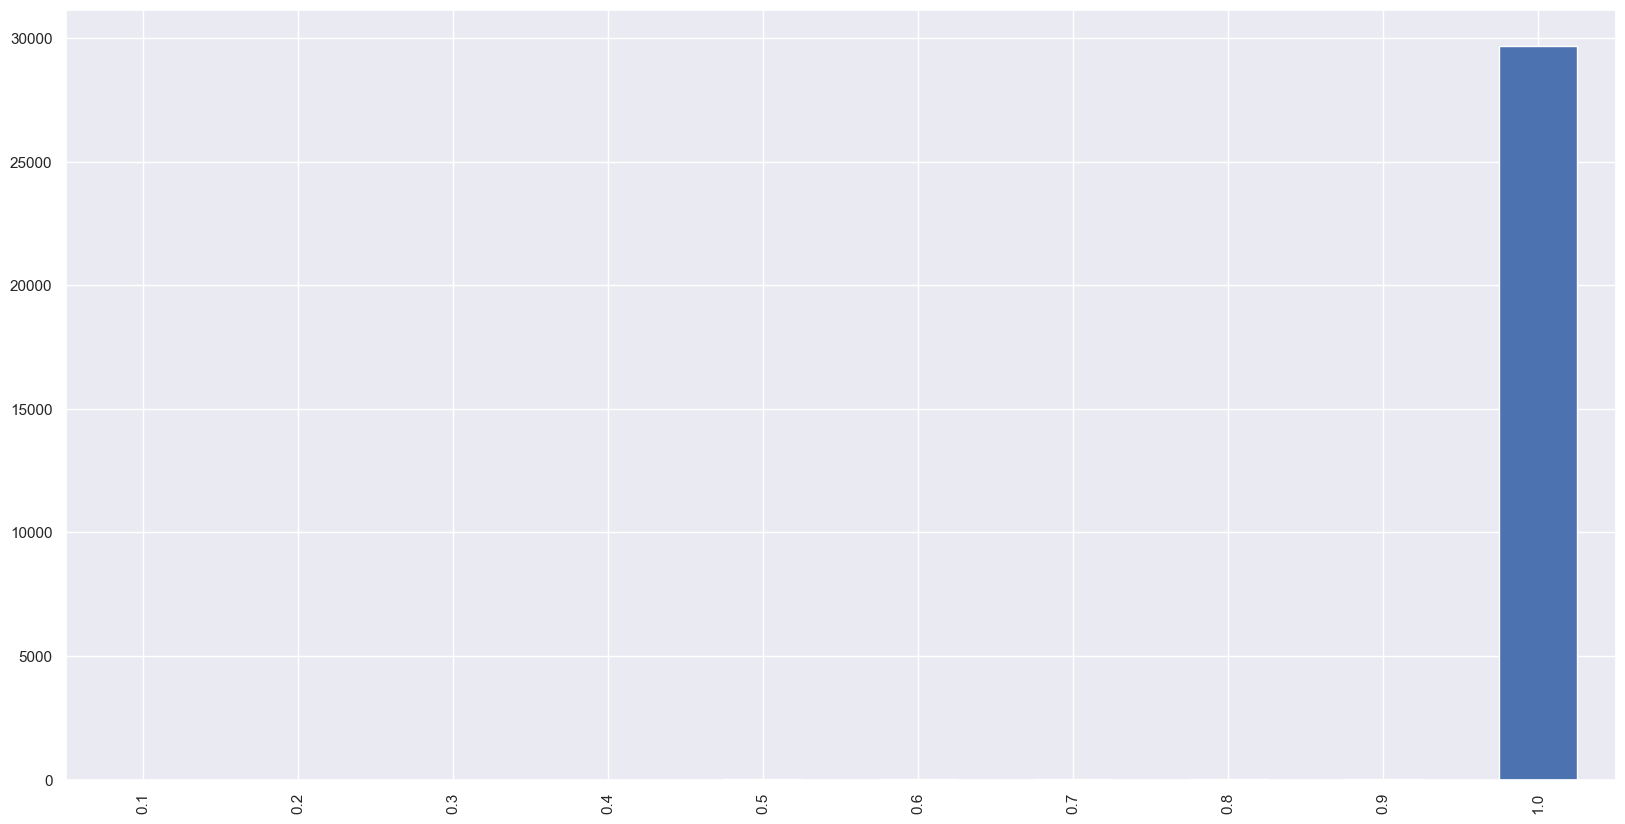

In [140]:
train_df[train_df['type'] == 1].drop_duplicates(subset=['aid'])['aid_count_type_1'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot(kind='bar')

<AxesSubplot:>

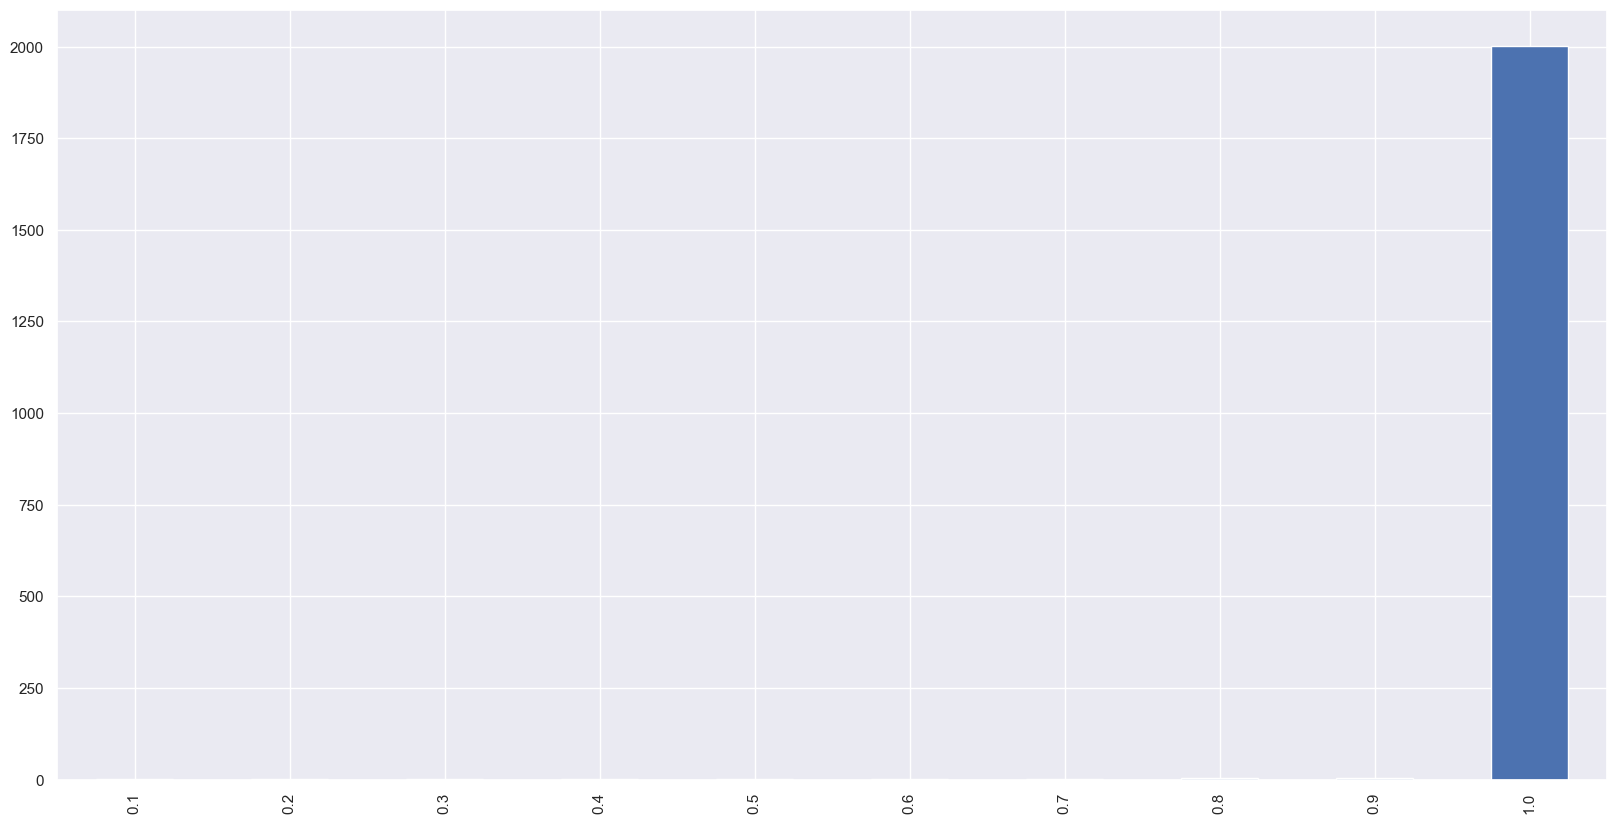

In [141]:
test_df[test_df['type'] == 1].drop_duplicates(subset=['aid'])['aid_count_type_1'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot(kind='bar')

<AxesSubplot:>

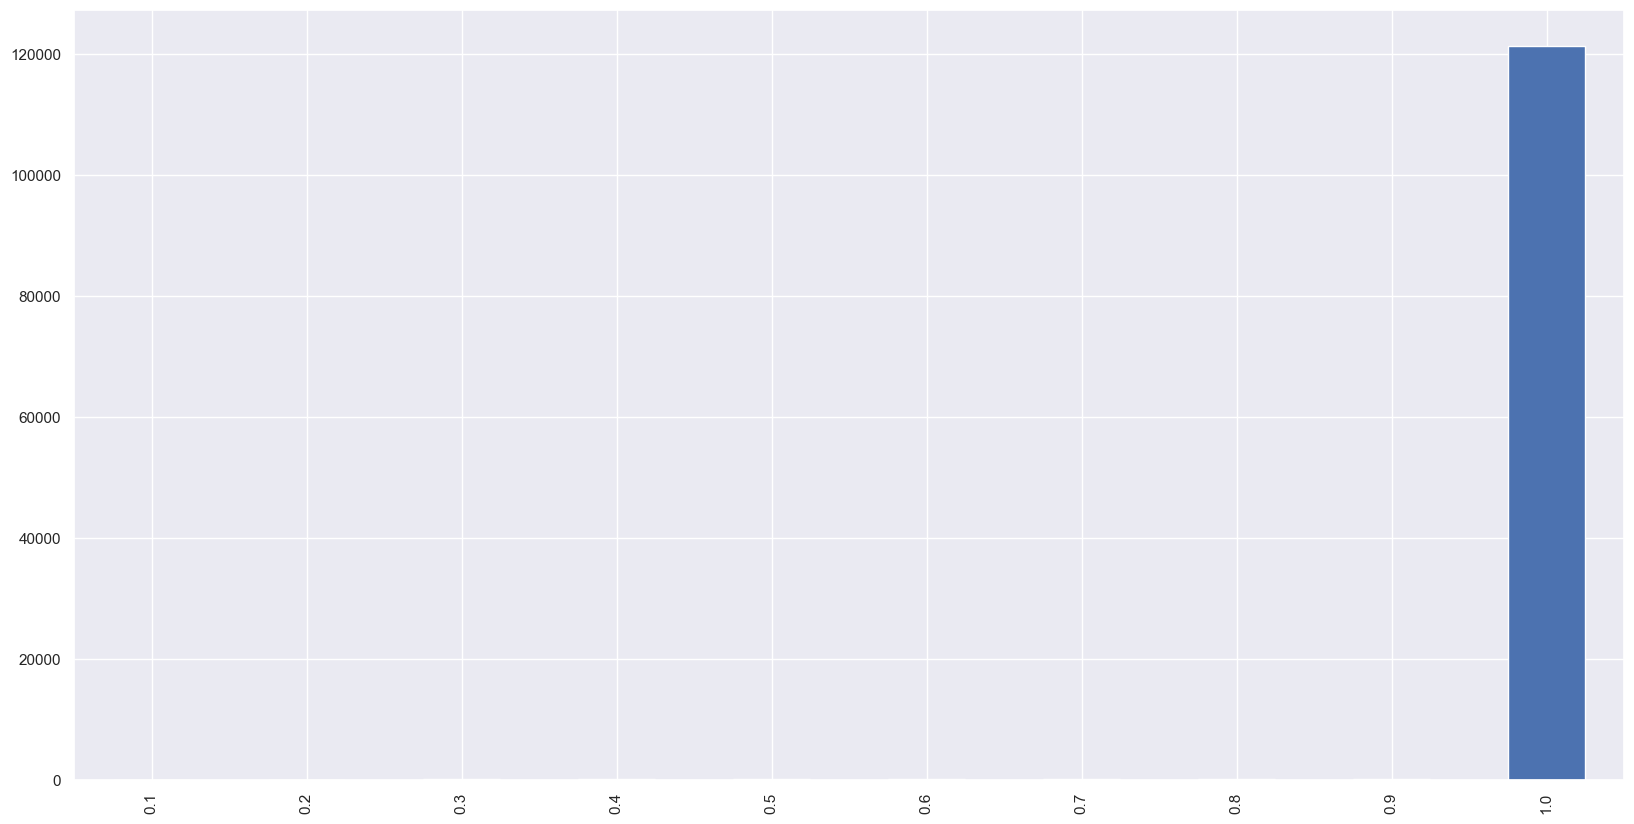

In [142]:
train_df[train_df['type'] == 0].drop_duplicates(subset=['aid'])['aid_count_type_0'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot(kind='bar')

<AxesSubplot:>

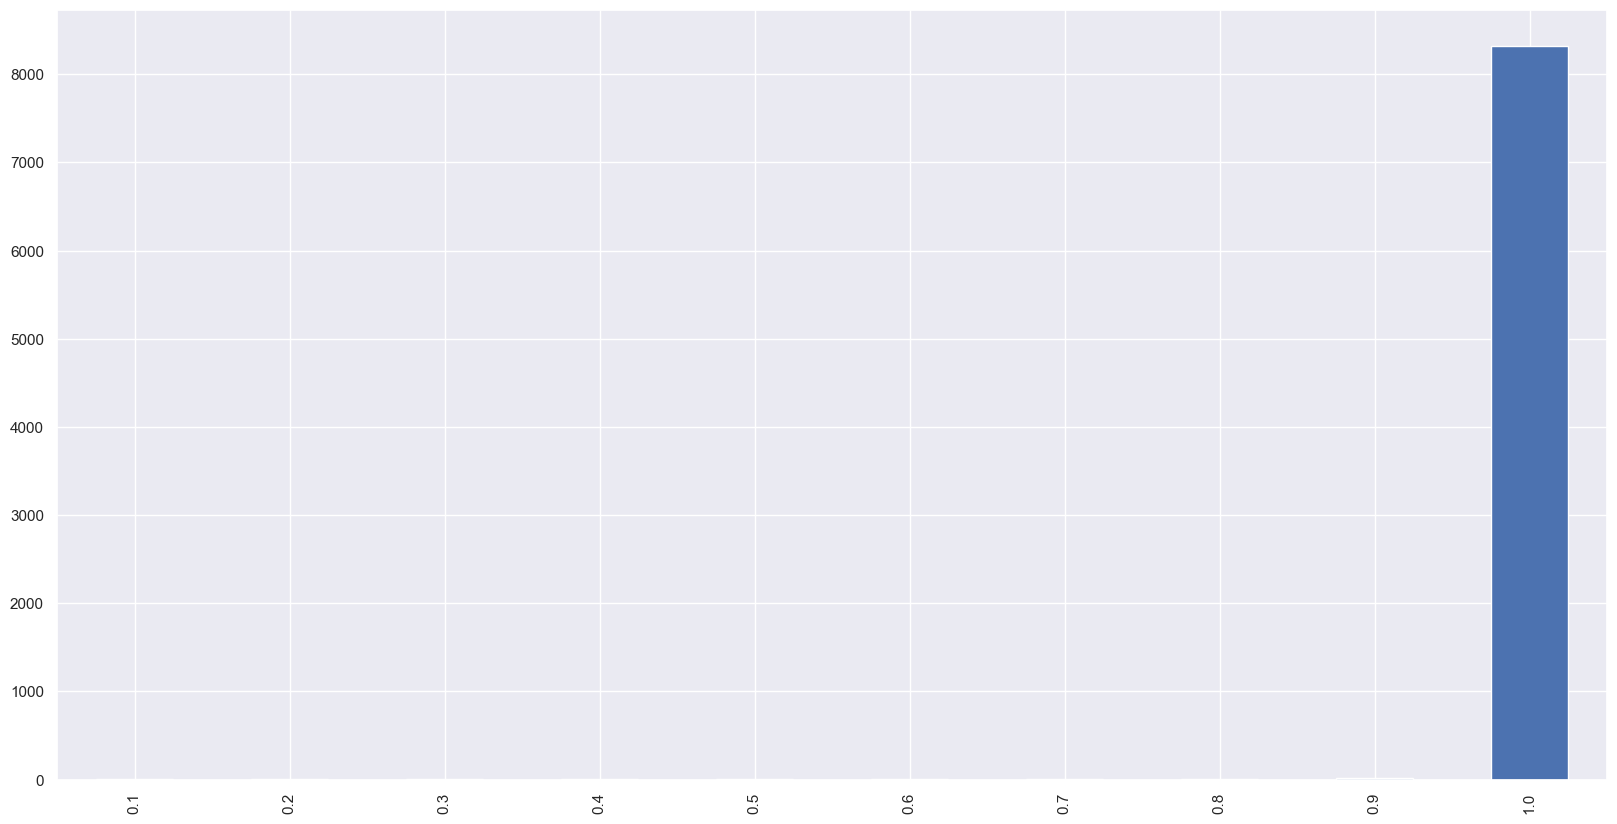

In [143]:
test_df[test_df['type'] == 0].drop_duplicates(subset=['aid'])['aid_count_type_0'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).plot(kind='bar')

### 3.2 Sessions bechavior

In [89]:
test_df.head()

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count_type_0,aid_count_type_1,aid_count_type_2,num_session_real_id
0,12899779,59625,1661724000278,0,0,0,12899779_0,1.0,0.0,0.0,1
1,12899780,1142000,1661724000378,0,0,0,12899780_0,473.0,0.0,0.0,5
2,12899780,582732,1661724058352,0,0,0,12899780_0,333.0,0.0,0.0,5
3,12899780,973453,1661724109199,0,0,0,12899780_0,87.0,0.0,0.0,5
4,12899780,736515,1661724136868,0,0,0,12899780_0,488.0,0.0,0.0,5


In [ ]:
# num real sessions

In [11]:
test_df['num_session_real_id'] = test_df.groupby('session_real_id')['session_real_id'].transform('count')
test_df.head(20)

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,aid_count_type_2,num_session_real_id
0,12899779,59625,1661724000278,0,0,0,12899779_0,1,1.0,0.0,0.0,1
1,12899780,1142000,1661724000378,0,0,0,12899780_0,511,473.0,0.0,0.0,5
2,12899780,582732,1661724058352,0,0,0,12899780_0,371,333.0,0.0,0.0,5
3,12899780,973453,1661724109199,0,0,0,12899780_0,94,87.0,0.0,0.0,5
4,12899780,736515,1661724136868,0,0,0,12899780_0,563,488.0,0.0,0.0,5
5,12899780,1142000,1661724155248,0,0,0,12899780_0,511,473.0,0.0,0.0,5
6,12899781,141736,1661724000559,0,0,3,12899781_0,253,231.0,0.0,0.0,4
7,12899781,199008,1661724022851,0,0,3,12899781_0,437,400.0,0.0,0.0,4
8,12899781,57315,1661724170835,0,0,3,12899781_0,1105,1047.0,0.0,0.0,4
9,12899781,194067,1661724246188,0,0,3,12899781_0,40,38.0,0.0,0.0,4


In [22]:
train_df['num_session_real_id'] = train_df.groupby('session_real_id')['session_real_id'].transform('count')


In [133]:
test_df.drop_duplicates(subset=['session_real_id'])['num_session_real'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     1.0
0.9     1.0
1.0    18.0
Name: num_session_real, dtype: float64

In [134]:
train_df.drop_duplicates(subset=['session_real_id'])['num_session_real'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      0.0
0.2      1.0
0.3      2.0
0.4      3.0
0.5      4.0
0.6      6.0
0.7      8.0
0.8     12.0
0.9     20.0
1.0    126.0
Name: num_session_real, dtype: float64

In [ ]:
#count unique aids for each real session and for each type type of actions

In [12]:
#// count number of unique aids in each session_real_id
train_df['num_unique_aid'] = train_df.groupby('session_real_id')['aid'].transform('nunique')
test_df['num_unique_aid'] = test_df.groupby('session_real_id')['aid'].transform('nunique')
test_df

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,aid_count_type_2,num_session_real_id,num_unique_aid
0,12899779,59625,1661724000278,0,0,0,12899779_0,1,1.0,0.0,0.0,1,1
1,12899780,1142000,1661724000378,0,0,0,12899780_0,511,473.0,0.0,0.0,5,4
2,12899780,582732,1661724058352,0,0,0,12899780_0,371,333.0,0.0,0.0,5,4
3,12899780,973453,1661724109199,0,0,0,12899780_0,94,87.0,0.0,0.0,5,4
4,12899780,736515,1661724136868,0,0,0,12899780_0,563,488.0,0.0,0.0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6928118,14571577,1141710,1662328774770,0,0,0,14571577_0,6,6.0,0.0,0.0,1,1
6928119,14571578,519105,1662328775009,0,0,0,14571578_0,8,8.0,0.0,0.0,1,1
6928120,14571579,739876,1662328775605,0,0,0,14571579_0,29,24.0,0.0,0.0,1,1
6928121,14571580,202353,1662328781067,0,0,0,14571580_0,20,19.0,0.0,0.0,1,1


In [13]:
train_df['num_unique_aid_0'] = train_df[train_df['type']==0].groupby('session_real_id')['aid'].transform('nunique')
train_df['num_unique_aid_1'] = train_df[train_df['type']==1].groupby('session_real_id')['aid'].transform('nunique')
train_df['num_unique_aid_2'] = train_df[train_df['type']==2].groupby('session_real_id')['aid'].transform('nunique')
train_df = train_df.fillna(0)

test_df['num_unique_aid_0'] = test_df[test_df['type']==0].groupby('session_real_id')['aid'].transform('nunique')
test_df['num_unique_aid_1'] = test_df[test_df['type']==1].groupby('session_real_id')['aid'].transform('nunique')
test_df['num_unique_aid_2'] = test_df[test_df['type']==2].groupby('session_real_id')['aid'].transform('nunique')
test_df = test_df.fillna(0)


In [112]:
train_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      1.0
0.2      1.0
0.3      1.0
0.4      1.0
0.5      2.0
0.6      2.0
0.7      3.0
0.8      5.0
0.9      8.0
1.0    486.0
Name: num_unique_aid, dtype: float64

In [113]:
test_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      1.0
0.2      1.0
0.3      1.0
0.4      1.0
0.5      1.0
0.6      2.0
0.7      2.0
0.8      3.0
0.9      5.0
1.0    433.0
Name: num_unique_aid, dtype: float64

In [114]:
train_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid_0'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      1.0
0.2      1.0
0.3      1.0
0.4      1.0
0.5      2.0
0.6      2.0
0.7      3.0
0.8      5.0
0.9      8.0
1.0    486.0
Name: num_unique_aid_0, dtype: float64

In [115]:
train_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid_1'].quantile([0.1, 0.2, 0.3, 0.4, 0.99, 0.992, 0.994, 0.996, 0.998, 1])


0.100     0.0
0.200     0.0
0.300     0.0
0.400     0.0
0.990     0.0
0.992     0.0
0.994     0.0
0.996     1.0
0.998     1.0
1.000    72.0
Name: num_unique_aid_1, dtype: float64

In [116]:
train_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid_2'].quantile([0.1, 0.2, 0.3, 0.4, 0.99, 0.992, 0.994, 0.996, 0.998, 1])

0.100     0.0
0.200     0.0
0.300     0.0
0.400     0.0
0.990     0.0
0.992     0.0
0.994     0.0
0.996     0.0
0.998     1.0
1.000    52.0
Name: num_unique_aid_2, dtype: float64

In [120]:
test_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid_0'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


0.1      1.0
0.2      1.0
0.3      1.0
0.4      1.0
0.5      1.0
0.6      2.0
0.7      2.0
0.8      3.0
0.9      5.0
1.0    433.0
Name: num_unique_aid_0, dtype: float64

In [121]:
test_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid_1'].quantile([0.1, 0.2, 0.3, 0.4, 0.99, 0.992, 0.994, 0.996, 0.998, 1])


0.100     0.0
0.200     0.0
0.300     0.0
0.400     0.0
0.990     0.0
0.992     0.0
0.994     0.0
0.996     0.0
0.998     1.0
1.000    31.0
Name: num_unique_aid_1, dtype: float64

In [122]:
test_df.drop_duplicates(subset=['session_real_id'])['num_unique_aid_2'].quantile([0.1, 0.2, 0.3, 0.4, 0.99, 0.992, 0.994, 0.996, 0.998, 1])

0.100     0.0
0.200     0.0
0.300     0.0
0.400     0.0
0.990     0.0
0.992     0.0
0.994     0.0
0.996     0.0
0.998     0.0
1.000    27.0
Name: num_unique_aid_2, dtype: float64

In [ ]:
#count unique aids for each user and for each type of actions

In [14]:
train_df['num_unique_aid_user'] = train_df.groupby('session')['aid'].transform('nunique')
test_df['num_unique_aid_user'] = test_df.groupby('session')['aid'].transform('nunique')

In [15]:
train_df['num_unique_aid_user_0'] = train_df[train_df['type']==0].groupby('session')['aid'].transform('nunique')
train_df['num_unique_aid_user_1'] = train_df[train_df['type']==1].groupby('session')['aid'].transform('nunique')
train_df['num_unique_aid_user_2'] = train_df[train_df['type']==2].groupby('session')['aid'].transform('nunique')
train_df = train_df.fillna(0)

test_df['num_unique_aid_user_0'] = test_df[test_df['type']==0].groupby('session')['aid'].transform('nunique')
test_df['num_unique_aid_user_1'] = test_df[test_df['type']==1].groupby('session')['aid'].transform('nunique')
test_df['num_unique_aid_user_2'] = test_df[test_df['type']==2].groupby('session')['aid'].transform('nunique')
test_df = test_df.fillna(0)

In [125]:
train_df.drop_duplicates(subset=['session'])['num_unique_aid_user'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      2.0
0.2      2.0
0.3      2.0
0.4      3.0
0.5      4.0
0.6      6.0
0.7      8.0
0.8     13.0
0.9     24.0
1.0    486.0
Name: num_unique_aid_user, dtype: float64

In [126]:
test_df.drop_duplicates(subset=['session'])['num_unique_aid_user'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      1.0
0.2      1.0
0.3      1.0
0.4      1.0
0.5      1.0
0.6      2.0
0.7      2.0
0.8      4.0
0.9      6.0
1.0    433.0
Name: num_unique_aid_user, dtype: float64

In [127]:
train_df.drop_duplicates(subset=['session'])['num_unique_aid_user_0'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      2.0
0.2      2.0
0.3      2.0
0.4      3.0
0.5      4.0
0.6      6.0
0.7      8.0
0.8     12.0
0.9     23.0
1.0    486.0
Name: num_unique_aid_user_0, dtype: float64

In [128]:
train_df.drop_duplicates(subset=['session'])['num_unique_aid_user_1'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      0.0
0.2      0.0
0.3      0.0
0.4      0.0
0.5      0.0
0.6      0.0
0.7      0.0
0.8      0.0
0.9      0.0
1.0    117.0
Name: num_unique_aid_user_1, dtype: float64

In [129]:
train_df.drop_duplicates(subset=['session'])['num_unique_aid_user_2'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0    63.0
Name: num_unique_aid_user_2, dtype: float64

In [130]:
test_df.drop_duplicates(subset=['session'])['num_unique_aid_user_0'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1      1.0
0.2      1.0
0.3      1.0
0.4      1.0
0.5      1.0
0.6      2.0
0.7      2.0
0.8      4.0
0.9      6.0
1.0    433.0
Name: num_unique_aid_user_0, dtype: float64

In [131]:
test_df.drop_duplicates(subset=['session'])['num_unique_aid_user_1'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0    44.0
Name: num_unique_aid_user_1, dtype: float64

In [132]:
test_df.drop_duplicates(subset=['session'])['num_unique_aid_user_2'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9     0.0
1.0    27.0
Name: num_unique_aid_user_2, dtype: float64

In [16]:
# // ordinary encoding session_real_id_encode in test_df and train_df dataframe with scikit learn OrdinalEncoder
enc = OrdinalEncoder()

test_df["session_real_id_encode"] = enc.fit_transform(test_df[["session_real_id"]])
test_df["session_real_id_encode"] = test_df["session_real_id_encode"].astype(int)

train_df['session_real_id_encode'] = enc.fit_transform(train_df[['session_real_id']])
train_df['session_real_id_encode'] = train_df['session_real_id_encode'].astype(int)

### 3.3 Test session bechavior

In [ ]:
### Paths ###
DATA_PATH = Path('../data')
TRAIN_RAW_PATH = DATA_PATH/'raw/train.jsonl'
TEST_RAW_PATH = DATA_PATH/'raw/test.jsonl'
SAMPLE_SUBMISSION_RAW_PATH = DATA_PATH/'raw/sample_submission.csv'

DATA_PROCESSED_PATH = DATA_PATH/'processed'

#// load data pandas
train_df_mod = pd.read_parquet(DATA_PROCESSED_PATH/'train_processed.parquet')
test_df_mod = pd.read_parquet(DATA_PROCESSED_PATH/'test_processed.parquet')

In [ ]:
test_df_mod.head()

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,...,num_session_real_id,num_unique_aid,num_unique_aid_0,num_unique_aid_1,num_unique_aid_2,num_unique_aid_user,num_unique_aid_user_0,num_unique_aid_user_1,num_unique_aid_user_2,session_real_id_encode
0,12899779,59625,1661724000278,0,0,0,12899779_0,1,1.0,0.0,...,1,1,1.0,0.0,0.0,1,1.0,0.0,0.0,0
1,12899780,1142000,1661724000378,0,0,0,12899780_0,511,473.0,0.0,...,5,4,4.0,0.0,0.0,4,4.0,0.0,0.0,1
2,12899780,582732,1661724058352,0,0,0,12899780_0,371,333.0,0.0,...,5,4,4.0,0.0,0.0,4,4.0,0.0,0.0,1
3,12899780,973453,1661724109199,0,0,0,12899780_0,94,87.0,0.0,...,5,4,4.0,0.0,0.0,4,4.0,0.0,0.0,1
4,12899780,736515,1661724136868,0,0,0,12899780_0,563,488.0,0.0,...,5,4,4.0,0.0,0.0,4,4.0,0.0,0.0,1


In [4]:
test_df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6928123 entries, 0 to 6928122
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   session                 int64  
 1   aid                     int64  
 2   ts                      int64  
 3   type                    uint8  
 4   session_real            int8   
 5   num_session_real        int8   
 6   session_real_id         object 
 7   aid_count               int64  
 8   aid_count_type_0        float64
 9   aid_count_type_1        float64
 10  aid_count_type_2        float64
 11  num_session_real_id     int64  
 12  num_unique_aid          int64  
 13  num_unique_aid_0        float64
 14  num_unique_aid_1        float64
 15  num_unique_aid_2        float64
 16  num_unique_aid_user     int64  
 17  num_unique_aid_user_0   float64
 18  num_unique_aid_user_1   float64
 19  num_unique_aid_user_2   float64
 20  session_real_id_encode  int64  
dtypes: float64(9), int64(8), int8(2

<AxesSubplot:ylabel='Frequency'>

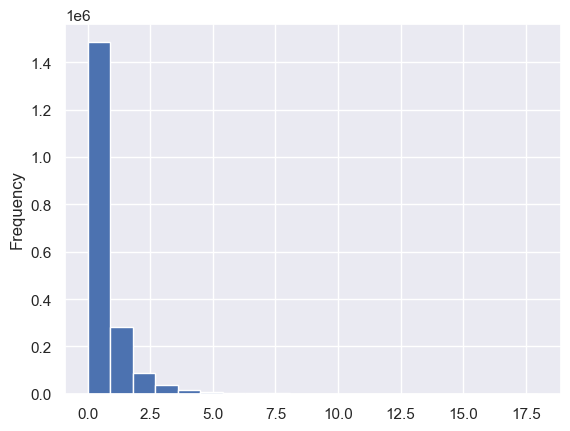

In [7]:
test_df_mod.drop_duplicates(subset=['session_real_id_encode'])['num_session_real'].plot(kind='hist', bins=20)

In [8]:
test_df_mod.drop_duplicates(subset=['session_real_id_encode'])

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,...,num_session_real_id,num_unique_aid,num_unique_aid_0,num_unique_aid_1,num_unique_aid_2,num_unique_aid_user,num_unique_aid_user_0,num_unique_aid_user_1,num_unique_aid_user_2,session_real_id_encode
0,12899779,59625,1661724000278,0,0,0,12899779_0,1,1.0,0.0,...,1,1,1.0,0.0,0.0,1,1.0,0.0,0.0,0
1,12899780,1142000,1661724000378,0,0,0,12899780_0,511,473.0,0.0,...,5,4,4.0,0.0,0.0,4,4.0,0.0,0.0,1
6,12899781,141736,1661724000559,0,0,3,12899781_0,253,231.0,0.0,...,4,4,4.0,0.0,0.0,5,5.0,0.0,0.0,2
10,12899781,199008,1661780623778,0,1,3,12899781_1,437,400.0,0.0,...,3,1,1.0,0.0,0.0,5,5.0,0.0,0.0,3
13,12899781,199008,1661804151788,0,2,3,12899781_2,437,400.0,0.0,...,1,1,1.0,0.0,0.0,5,5.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6928118,14571577,1141710,1662328774770,0,0,0,14571577_0,6,6.0,0.0,...,1,1,1.0,0.0,0.0,1,1.0,0.0,0.0,1927205
6928119,14571578,519105,1662328775009,0,0,0,14571578_0,8,8.0,0.0,...,1,1,1.0,0.0,0.0,1,1.0,0.0,0.0,1927206
6928120,14571579,739876,1662328775605,0,0,0,14571579_0,29,24.0,0.0,...,1,1,1.0,0.0,0.0,1,1.0,0.0,0.0,1927207
6928121,14571580,202353,1662328781067,0,0,0,14571580_0,20,19.0,0.0,...,1,1,1.0,0.0,0.0,1,1.0,0.0,0.0,1927208


<AxesSubplot:ylabel='Frequency'>

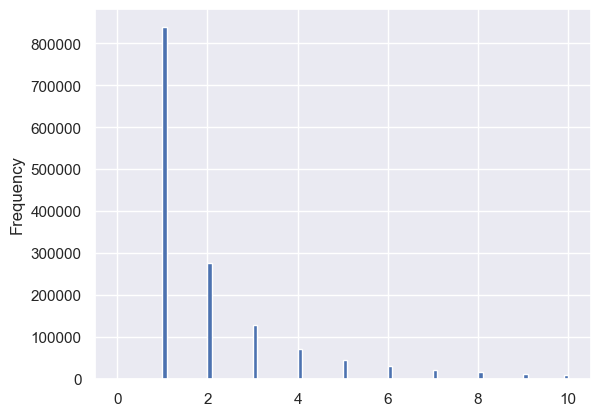

In [12]:
test_df_mod.drop_duplicates(subset=["session_real_id_encode"])[
    test_df_mod.num_session_real == 0
]["num_unique_aid"].plot(kind="hist", bins=100, range=(0,10))

<AxesSubplot:ylabel='Frequency'>

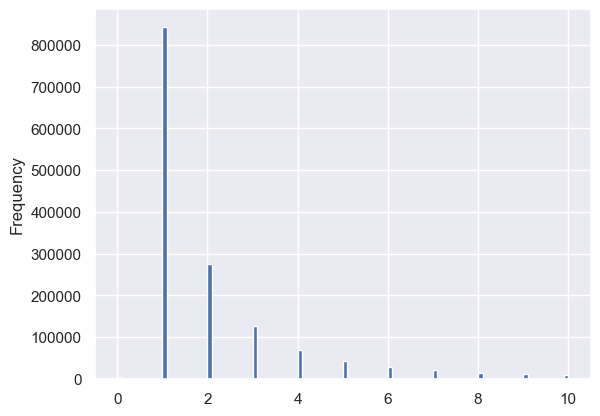

In [16]:
test_df_mod.drop_duplicates(subset=["session_real_id_encode"])[
    test_df_mod.num_session_real == 0
]["num_unique_aid_0"].plot(kind="hist", bins=100, range=(0,10))

<AxesSubplot:ylabel='Frequency'>

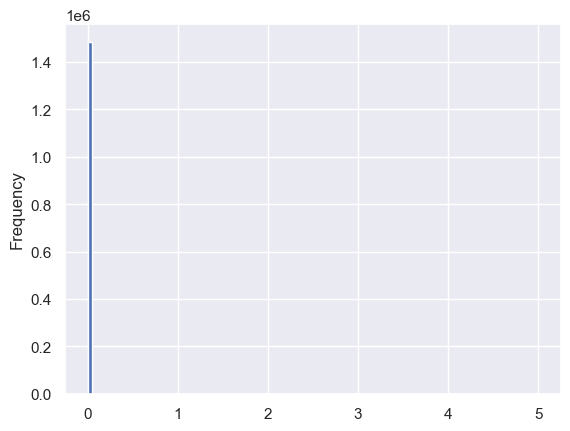

In [19]:
test_df_mod.drop_duplicates(subset=["session_real_id_encode"])[
    test_df_mod.num_session_real == 0
]["num_unique_aid_2"].plot(kind="hist", bins=100, range=(0,5))

<AxesSubplot:ylabel='Frequency'>

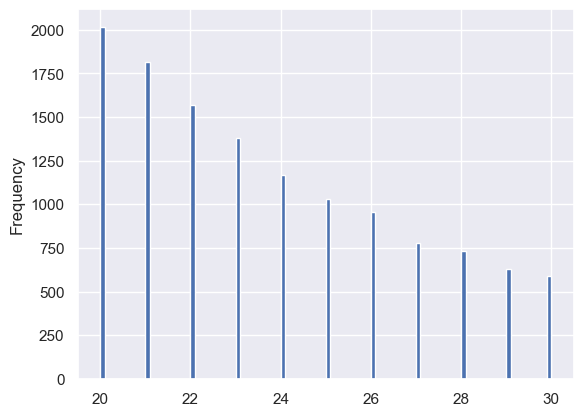

In [15]:
test_df_mod.drop_duplicates(subset=["session_real_id_encode"])["num_unique_aid"].plot(kind="hist", bins=100, range=(20,30))

In [ ]:
test_df_mod.drop_duplicates(subset=["session_real_id_encode"])["num_unique_aid_2"].plot(kind="hist", bins=100, range=(0,30))

<AxesSubplot:ylabel='Frequency'>

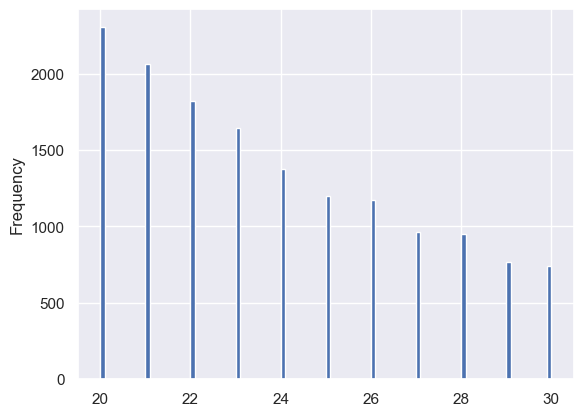

In [14]:
test_df_mod.drop_duplicates(subset=["session"])["num_unique_aid_user"].plot(kind="hist", bins=100, range=(20,30))

In [17]:
# write data
train_df.to_parquet(DATA_PROCESSED_PATH/'train_processed.parquet', index=False)
test_df.to_parquet(DATA_PROCESSED_PATH/'test_processed.parquet', index=False)

## 4.Baseline

In [22]:
with open(TEST_RAW_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the test data")

We have 1,671,803 lines in the test data


In [23]:
# Load in a sample to a pandas df

sample_size = 150

chunks = pd.read_json(TEST_RAW_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_test_df = c
    break

In [24]:
sample_test_df.head()

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [27]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_RAW_PATH)
sample_submission.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


In [28]:
sample_size = 150000

chunks = pd.read_json(TRAIN_RAW_PATH, lines=True, chunksize = sample_size)

clicks_article_list = []
carts_article_list = []
orders_article_list = []

for e, c in enumerate(chunks):
    
    # Save time by not using all the data
    if e > 2:
        break
    
    sample_train_df = c
    
    for i, row in c.iterrows():
        actions = row['events']
        for action in actions:
            if action['type'] == 'clicks':
                clicks_article_list.append(action['aid'])
            elif action['type'] == 'carts':
                carts_article_list.append(action['aid'])
            else:
                orders_article_list.append(action['aid'])

In [31]:
# Create dictionaries with articles and their frequencies
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [32]:
# Get the 20 most frequent articles for each action
top_click_article = nlargest(20, article_click_freq, key = article_click_freq.get)
top_carts_article = nlargest(20, article_carts_freq, key = article_carts_freq.get)
top_order_article = nlargest(20, article_order_freq, key = article_order_freq.get)

In [33]:
# Create a dict with this info
frequent_articles = {'clicks': top_click_article, 'carts':top_carts_article, 'order':top_order_article}

In [34]:
for action in ['clicks', 'carts', 'order']:
    print(f'Most frequent articles for {action}: {frequent_articles[action][:5]}')

Most frequent articles for clicks: [29735, 1733943, 108125, 1603001, 832192]
Most frequent articles for carts: [80222, 29735, 1733943, 166037, 485256]
Most frequent articles for order: [80222, 166037, 1022566, 351335, 1629608]


In [35]:
test_data = pd.read_json(TEST_PATH, lines=True, chunksize=1000)

preds = []

for chunk in tqdm(test_data, total=1671):
    
    for i, row in chunk.iterrows():
        actions = row['events']
        article_id_list = []
        for action in actions:
            article_id_list.append(action['aid'])
            
        # Get 20 most common article ID for the session
        article_freq = Counter(article_id_list)
        top_articles = nlargest(20, article_freq, key = article_freq.get)
        
        # Pad with most popular items in training
        padding_size = (20 - len(top_articles)) 
        for action in ['clicks', 'carts', 'order']:
            top_articles_added = top_articles + frequent_articles[action][:padding_size] 
            preds.append(" ".join([str(id) for id in top_articles_added]))

  0%|          | 0/1671 [00:00<?, ?it/s]

In [36]:
# Predict the 20 most common atricles for each test session
sample_submission['labels'] = preds


In [37]:
sample_submission.to_csv('submission.csv', index=False)


In [40]:
!kaggle competitions submit -c otto-recommender-system -f submission.csv -m "Message"

100%|████████████████████████████████████████| 770M/770M [10:25<00:00, 1.29MB/s]
Traceback (most recent call last):
  File "/Users/Artem_Boltaev/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/Artem_Boltaev/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/Artem_Boltaev/opt/anaconda3/lib/python3.9/http/client.py", line 1377, in getresponse
    response.begin()
  File "/Users/Artem_Boltaev/opt/anaconda3/lib/python3.9/http/client.py", line 320, in begin
    version, status, reason = self._read_status()
  File "/Users/Artem_Boltaev/opt/anaconda3/lib/python3.9/http/client.py", line 281, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/Artem_Boltaev/opt/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    r